# 1. Matrix Factorization using sklearn's NMF and RMSE Calculation

In this section, I loaded the movie ratings data and applied sklearn's Non-Negative Matrix Factorization (NMF) technique to predict the missing ratings. NMF cannot handle missing values (`NaN`) directly, so I filled the missing values with the average rating for each user. This method of imputation provides a simple way to handle the missing data, but it may lead to biased predictions, especially for users with few ratings or inconsistent rating behavior.

In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training and test data
train_data = pd.read_csv('C:/Python/ML_w3/data/train.csv')
test_data = pd.read_csv('C:/Python/ML_w3/data/test.csv')

# Create the user-item matrix for training data
ratings_matrix = train_data.pivot(index='uID', columns='mID', values='rating')

# Use user's average rating to fill NaN values
ratings_matrix_filled = ratings_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)

# Display the first few rows of the filled matrix to confirm the processing
print(ratings_matrix_filled.head())

mID      1         2         3         4         5         6         7     \
uID                                                                         
1    5.000000  4.214286  4.214286  4.214286  4.214286  4.214286  4.214286   
2    3.648936  3.648936  3.648936  3.648936  3.648936  3.648936  3.648936   
3    3.914286  3.914286  3.914286  3.914286  3.914286  3.914286  3.914286   
4    3.928571  3.928571  3.928571  3.928571  3.928571  3.928571  3.928571   
5    3.136986  3.136986  3.136986  3.136986  3.136986  2.000000  3.136986   

mID      8         9         10    ...      3943      3944      3945  \
uID                                ...                                 
1    4.214286  4.214286  4.214286  ...  4.214286  4.214286  4.214286   
2    3.648936  3.648936  3.648936  ...  3.648936  3.648936  3.648936   
3    3.914286  3.914286  3.914286  ...  3.914286  3.914286  3.914286   
4    3.928571  3.928571  3.928571  ...  3.928571  3.928571  3.928571   
5    3.136986  3.136986  3.1

RMSE of the NMF model: 1.0238


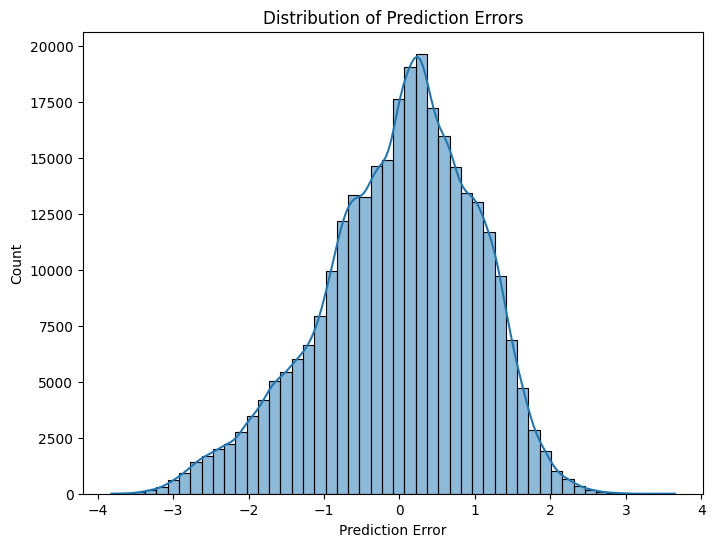

In [20]:
# Apply NMF to the user-item matrix
nmf_model = NMF(n_components=20, init='random', random_state=42, solver='mu', tol=1e-3, max_iter=500)
W = nmf_model.fit_transform(ratings_matrix_filled)  # User-feature matrix
H = nmf_model.components_  # Feature-item matrix

# Reconstruct the matrix using W and H to predict missing values
predicted_matrix = np.dot(W, H)
predicted_ratings = pd.DataFrame(predicted_matrix, index=ratings_matrix.index, columns=ratings_matrix.columns)

# Merge the test data with the predicted ratings
predicted_ratings_flat = predicted_ratings.stack().reset_index()
predicted_ratings_flat.columns = ['uID', 'mID', 'predicted_rating']
merged_data = pd.merge(test_data, predicted_ratings_flat, on=['uID', 'mID'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(merged_data['rating'], merged_data['predicted_rating']))
print(f"RMSE of the NMF model: {rmse:.4f}")

# Visualize the distribution of prediction errors
errors = merged_data['rating'] - merged_data['predicted_rating']
plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=50, kde=True)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.show()


The RMSE value of **1.0238** suggests that the NMF model is able to predict user ratings with a reasonable degree of accuracy. However, compared to baseline methods such as the user mean, which yielded an RMSE of **1.0353**, or similarity-based methods like cosine similarity, which achieved an RMSE of **1.0263**, and Jaccard similarity, which achieved an RMSE of **0.9456**, the NMF model does not outperform these simpler methods. This could be due to the challenges of imputing missing data and the model's sensitivity to the number of latent factors.

### Factors Affecting Performance

The performance of the NMF model was influenced by several factors. First, the missing values in the user-item matrix were filled using the average rating for each user. While this method simplifies the imputation process, it assumes that each user has a consistent rating behavior, which can introduce bias, especially for users with few or inconsistent ratings. More sophisticated imputation methods, such as item-based averages or K-Nearest Neighbors (KNN), could improve performance. Second, the number of latent factors (`n_components`) was set to 20 in this experiment. The choice of `n_components` is critical, as a low value may fail to capture the data's underlying structure, while a high value may lead to overfitting. Cross-validation could be used to optimize this parameter and improve results. Lastly, regularization techniques could mitigate the risk of overfitting, especially in complex models, encouraging better generalization to unseen data.

##### Reference: my RMSE results from HW3:
- **Baseline, 𝑌𝑝 = 3**: 1.2586
- **Baseline, 𝑌𝑝 = 𝜇𝑢**: 1.0353
- **Content-based (item-item)**: 1.0125
- **Collaborative (cosine)**: 1.0263
- **Collaborative, jaccard, 𝑀𝑟 ≥ 3**: 0.9820
- **Collaborative, jaccard, 𝑀𝑟 ≥ 1**: 0.9914
- **Collaborative, jaccard (original)**: 0.9456

# 2. Discussion

### Comparison with Baseline Methods

Baseline methods, such as using the user’s average rating or the global average rating, are simple and generally provide stable results. These methods excel in their simplicity, often outperforming more complex models like NMF, particularly when the number of latent factors (`n_components`) in NMF is not carefully tuned. Baseline methods are less prone to overfitting and can be surprisingly effective due to their robustness, especially when dealing with sparse data.

### Comparison with Similarity-Based Methods

Similarity-based methods, such as cosine similarity or Jaccard similarity, exploit direct user-user or item-item relationships. They perform well in sparse datasets by leveraging the existing ratings and relationships between users or items. These methods are particularly effective because they focus on the available ratings, and are not overly impacted by missing values. In contrast, NMF requires an imputation strategy for missing values, which can introduce bias. This reliance on imputed data often leads to worse performance when compared to similarity-based approaches, which can make use of the direct relationships without requiring such imputation.

### Limitations of NMF and Possible Improvements

One significant limitation of NMF is its inability to directly handle missing values (`NaN`). In this experiment, missing values were filled using the user's average rating, which can distort predictions, particularly when a user has rated only a few items. A more sophisticated approach, such as K-Nearest Neighbors (KNN) or machine learning-based imputation, could improve the accuracy of predictions. Additionally, the performance of NMF is highly sensitive to the number of latent factors (`n_components`). If this value is too low, the model may fail to capture the underlying patterns in the data. Conversely, setting it too high may result in overfitting. Using cross-validation to systematically select the optimal number of latent factors could address this issue. Finally, the introduction of regularization techniques could further improve NMF's performance by preventing overfitting, ensuring the model generalizes better to unseen data.